In [51]:
%run 09_baseline_model.ipynb

In [52]:
import joblib
import pandas as pd
import numpy as np

var = joblib.load('../cache/var_model.joblib')
dfm = joblib.load('../cache/dfm_model.joblib')
varmax = joblib.load('../cache/varmax_model.joblib')
naive = joblib.load('../cache/naive_model.joblib')

test_data = pd.read_parquet('../cache/test_data.parquet')
train_data = pd.read_parquet('../cache/train_data.parquet')
btc_cleaned = pd.read_parquet('../cache/btc_cleaned.parquet')
btc = pd.read_parquet('../cache/btc.parquet')

In [53]:
train_data.head()

,AvgTone,GoldsteinScale,NumSources,NumArticles,Actor1Country_enc,Actor1GeoCountry_enc,Actor1Type_enc,Actor2Country_enc,Actor2GeoCountry_enc,Actor2Type_enc,ActionCountry_enc,EventType_enc,pct_change_30min
Date,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.175964,1.817205,0.521607,-0.247790,0.409021,1.086753,-0.032773,2.829239,-1.613906,0.050958,-0.726077,1.553270,-0.226363
2019-01-01 00:15:00,0.349194,-0.278203,-0.074356,-0.121287,0.409021,0.440374,-0.032773,0.106576,0.048803,0.050958,0.401003,0.144686,-2.578560
2019-01-01 00:30:00,-0.290151,0.245649,4.097383,4.306286,-2.322466,-0.529194,-0.032773,0.106576,0.603040,0.050958,1.152390,0.144686,-1.509301
2019-01-01 00:45:00,3.491408,0.664730,-0.670319,-0.374292,0.409021,1.086753,-0.032773,0.106576,0.603040,0.050958,1.152390,0.144686,0.781614
2019-01-01 01:00:00,-0.094624,-0.627438,-0.074356,-0.121287,-1.639595,-0.852384,-0.032773,0.106576,-1.613906,0.050958,-0.726077,0.614214,-0.291943


In [54]:
lag_order = var.k_ar
past_observations = test_data.values[:lag_order]
steps = 35040  # 365 days * 24 hours * 4 (15min intervals)

# DataFrames to store predictions
naive_predictions = []
var_predictions = []
dfm_predictions = []
varmax_predictions = []

for step in range(steps // 10):
    # Naive model prediction
    step = step*10
    naive_pred = naive.forecast(steps=10)
    naive_predictions.append(naive_pred.values)

    # VAR model prediction
    var_pred = var.forecast(past_observations, steps=10)
    var_predictions.append(var_pred)

    # DFM model prediction
    dfm_pred = dfm.get_forecast(steps=10).predicted_mean.values[0]
    dfm_predictions.append(dfm_pred)

    # VARMAX model prediction
    varmax_pred = varmax.forecast(steps=10)
    varmax_predictions.append(varmax_pred.values[0])

    if step + lag_order < len(test_data):
        past_observations = np.vstack([past_observations, test_data.values[step + lag_order]])

    if step % 100 == 0:
        print(f"Step {step} of {steps} completed.")

Step 0 of 35040 completed.
Step 100 of 35040 completed.
Step 200 of 35040 completed.
Step 300 of 35040 completed.
Step 400 of 35040 completed.
Step 500 of 35040 completed.
Step 600 of 35040 completed.
Step 700 of 35040 completed.
Step 800 of 35040 completed.
Step 900 of 35040 completed.
Step 1000 of 35040 completed.
Step 1100 of 35040 completed.
Step 1200 of 35040 completed.
Step 1300 of 35040 completed.
Step 1400 of 35040 completed.
Step 1500 of 35040 completed.
Step 1600 of 35040 completed.
Step 1700 of 35040 completed.
Step 1800 of 35040 completed.
Step 1900 of 35040 completed.
Step 2000 of 35040 completed.
Step 2100 of 35040 completed.
Step 2200 of 35040 completed.
Step 2300 of 35040 completed.
Step 2400 of 35040 completed.
Step 2500 of 35040 completed.
Step 2600 of 35040 completed.
Step 2700 of 35040 completed.
Step 2800 of 35040 completed.
Step 2900 of 35040 completed.
Step 3000 of 35040 completed.
Step 3100 of 35040 completed.
Step 3200 of 35040 completed.
Step 3300 of 35040 com

In [55]:
# naive_predictions

[array([[-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.265

In [56]:
naive_predictions_flat = [row.tolist() for array in naive_predictions for row in array]

In [57]:
# # get results for the models
# lag_order = var.k_ar
# last_obs = train_data.values[-lag_order:]
# naive_results = naive.forecast(steps=35039)
# var_results = var.forecast(last_obs, steps=35039)
# dfm_results = dfm.get_forecast(steps=35039)
# varmax_results = varmax.forecast(steps=35039)

In [58]:
# import torch
# feature_cols = [
#     'Actor1Country', 'Actor1GeoCountry', 'Actor1Type',
#     'Actor2Country', 'Actor2GeoCountry', 'Actor2Type',
#     'ActionCountry', 'EventType', 'GoldsteinScale',
#     'NumSources', 'NumArticles', 'AvgTone',
#     'Magnitude', 'Impact'
# ]
# X_new = test_data[feature_cols].values
# X_new_tensor = torch.FloatTensor(X_new)
# nn_model.eval()
# nn_results_array = []
# for i in range(35039):
#     nn_results = nn_model(X_new_tensor)
#     nn_results_array.append(nn_results)
#     X_new_tensor = torch.cat((X_new_tensor[1:], nn_results)) # tensor is with 14 columns but result has only 1

In [59]:
var_predictions_reshaped = np.array(var_predictions).reshape(-1, train_data.shape[1])

dfm_df = pd.DataFrame(dfm_predictions, columns=train_data.columns)
naive_df = pd.DataFrame(naive_predictions_flat, columns=train_data.columns)
var_df = pd.DataFrame(var_predictions_reshaped, columns=train_data.columns)
varmax_df = pd.DataFrame(varmax_predictions, columns=train_data.columns)

In [60]:
dfm_df.head()

,AvgTone,GoldsteinScale,NumSources,NumArticles,Actor1Country_enc,Actor1GeoCountry_enc,Actor1Type_enc,Actor2Country_enc,Actor2GeoCountry_enc,Actor2Type_enc,ActionCountry_enc,EventType_enc,pct_change_30min
0,0.002481,0.007726,-0.012923,-0.011516,-0.00828,0.068678,-0.000216,0.01113,0.012335,-0.000694,0.065296,-0.005666,0.003274
1,0.002481,0.007726,-0.012923,-0.011516,-0.00828,0.068678,-0.000216,0.01113,0.012335,-0.000694,0.065296,-0.005666,0.003274
2,0.002481,0.007726,-0.012923,-0.011516,-0.00828,0.068678,-0.000216,0.01113,0.012335,-0.000694,0.065296,-0.005666,0.003274
3,0.002481,0.007726,-0.012923,-0.011516,-0.00828,0.068678,-0.000216,0.01113,0.012335,-0.000694,0.065296,-0.005666,0.003274
4,0.002481,0.007726,-0.012923,-0.011516,-0.00828,0.068678,-0.000216,0.01113,0.012335,-0.000694,0.065296,-0.005666,0.003274


In [61]:
naive_df.head()

,AvgTone,GoldsteinScale,NumSources,NumArticles,Actor1Country_enc,Actor1GeoCountry_enc,Actor1Type_enc,Actor2Country_enc,Actor2GeoCountry_enc,Actor2Type_enc,ActionCountry_enc,EventType_enc,pct_change_30min
0,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
1,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
2,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
3,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
4,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106


<Axes: xlabel='Date', ylabel='pct_change_30min'>

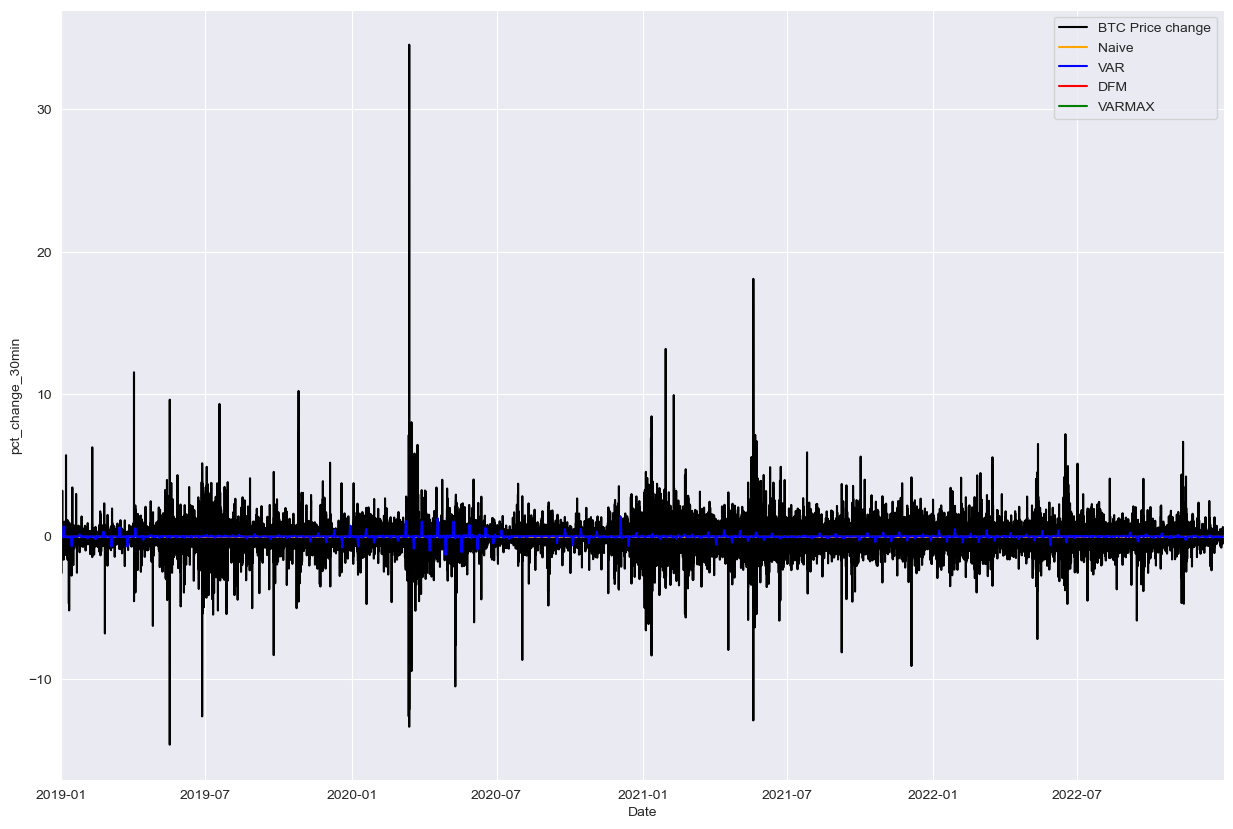

In [62]:
# plot btc 30min price and all the models
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 10))
plt.xlim(pd.to_datetime('2019-01-01 00:00:00'), pd.to_datetime('2022-12-31 23:45:00'))
sns.lineplot(data=train_data['pct_change_30min'], ax=ax, label='BTC Price change', color='black')
sns.lineplot(data=naive_df['pct_change_30min'], ax=ax, label='Naive', color='orange')
sns.lineplot(data=var_df['pct_change_30min'], ax=ax, label='VAR', color='blue')
sns.lineplot(data=dfm_df['pct_change_30min'], ax=ax, label='DFM', color='red')
sns.lineplot(data=varmax_df['pct_change_30min'], ax=ax, label='VARMAX', color='green')


In [63]:
test_data = test_data[lag_order:]

In [64]:
test_data.shape

(35025, 13)

In [65]:
dfm_df = dfm_df[:-lag_order]
naive_df = naive_df[:-lag_order]
var_df = var_df[:-lag_order]
varmax_df = varmax_df[:-lag_order]

In [66]:
# if pct_change_30min is negative then set it to 0, if pct_change_30min is positive then set it to 1
naive_signal = naive_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
var_signal = var_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
dfm_signal = dfm_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
varmax_signal = varmax_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
btc_signal = train_data['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)

In [67]:
btc.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [68]:
btc['Datetime'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.set_index('Datetime', inplace=True)

date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:45:00', freq='15min')
btc = btc.reindex(date_range)
btc = btc.interpolate()

# btc prices in 15min intervals
btc_prices = btc['Open']

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_strategy(price_df, prediction_df, strategy_function):
    """
    Backtests a trading strategy based on price and prediction data.

    Args:
        price_df (pd.DataFrame): DataFrame with 'timestamp' and 'price' columns.
        prediction_df (pd.DataFrame): DataFrame with 'timestamp' and 'prediction' columns.
        strategy_function (callable): Function accepting price, actual change and pred. change and implements strategy
            returning score.

    Returns:
        pd.DataFrame: DataFrame with backtest results
    """

    merged_df = pd.merge(price_df, prediction_df, on=prediction_df.index, how='inner') # merge datas on timestamps

    merged_df['actual_change'] = np.nan

    for i in range(len(merged_df) - 2):
        merged_df.loc[i, 'actual_change'] = merged_df.loc[i + 2, 'price'] - merged_df.loc[i, 'price'] # calculate actual change

    merged_df.dropna(inplace=True) # remove last 2 rows (cant calculate actual change for them)
    backtest_results = []
    score = 0;
    for index, row in merged_df.iterrows():
        score = score + strategy_function(row['price'],row['actual_change'], row['prediction']) # implement  strategy function and accumulating score
        backtest_results.append(score)

    merged_df['strategy_score']  = backtest_results #add score to df

    return merged_df


def simple_strategy(price,actual_change, predicted_change, threshold = 0):
    """
    A simple example strategy that trades based on the predicted change. returns a score (not profit)
            Args:
                price (float): current price
                actual_change (float): actual 30 min change
                predicted_change (float): predicted 30 min change
                threshold (float): threshold value when prediction must be higher to act
            Returns:
               score (float): changes how well the bot is doing
    """
    if predicted_change > threshold:
       return   actual_change # predicted up and it did go up = good
    elif predicted_change < -threshold:
        return - actual_change # predicted down and it did go down = good
    else:
       return 0 # not trading



# Sample data (replace with your actual data)
data_prices = btc_prices

data_predictions = var_df['pct_change_30min']


price_df = pd.DataFrame(data_prices)
prediction_df = pd.DataFrame(data_predictions)




In [70]:
# btc_prices.head()

In [71]:
# results_df.tail()

In [74]:
# Run the backtest with the strategy that predicts up  or down
results_df = backtest_strategy(price_df, prediction_df,simple_strategy)

# Print results
print(results_df)

# Plotting score
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(results_df.index, results_df['strategy_score'], label='strategy_score')
plt.xlabel('Timestamp')
plt.ylabel('Strategy Score')
plt.title('Strategy Score Over Time')
plt.grid(True)
plt.legend()
plt.show()

KeyError: RangeIndex(start=0, stop=35025, step=1)

In [22]:
# money = 1000000
# btc_holdings = 1
# portfolio_values = []
#
# signals = [naive_signal, var_signal, dfm_signal, varmax_signal, btc_signal]
# signal_names = ['Naive', 'VAR', 'DFM', 'VARMAX', 'BTC']
# min_length = min(len(btc_prices), len(signals[0]))
#
# for j in range(len(signals)):
#     signal = signals[j]
#     for i in range(min_length):
#         current_price = btc_prices.iloc[i]
#         if signal.iloc[i] == 1:
#             # Buy 1 BTC
#             money -= current_price
#             btc_holdings += 1
#         elif signal.iloc[i] == 0:
#             # Sell 1 BTC
#             money += current_price
#             btc_holdings -= 1
#         portfolio_value = money + btc_holdings * current_price
#         portfolio_values.append(portfolio_value)
#     print(f"{signal_names[j]}: {portfolio_values[-1]}")